# predictNextApp

This model predicts 8 apps that the user will use next based on the user's previous app usage history.

# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt




2023-07-15 15:15:27.554846: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 15:15:28.292009: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [39]:
original_df = pd.read_csv('Datasets/archive/train.csv')
print("Number of entries: ", len(original_df))
original_df.head()

df = original_df.copy()

Number of entries:  79339


# DATA PROCESSING
### Nans
To spare me any headaches later, I am going to remove all nans

In [3]:
df = df[df["Duration"].notna()]

### Time-related columns
Transforms the Duration column to a integer (seconds)

In [4]:
df['Duration'] = pd.to_datetime(original_df['Duration'])
# Replaces datetime for seconds
df["Duration"] = df["Duration"].dt.hour * 60 + df["Duration"].dt.minute * 60 + df["Duration"].dt.second
# Converts to int
df["Duration"] = df["Duration"].astype(int)

# Feature engineering for "Date" and "Time" columns

df["Date"] = pd.to_datetime(original_df["Date"])
df["Time"] = pd.to_datetime(original_df["Time"])

# Extract hour, minute, weekday and month from these columns and put it in new ones
df["Weekday"] = df["Date"].dt.day_of_week.astype(int)
df["Month"] = df["Date"].dt.month.astype(int)
df["Hour"] = df["Time"].dt.hour.astype(int)
df["Minute"] = df["Time"].dt.minute.astype(int)

/tmp/ipykernel_16304/398935141.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Duration'] = pd.to_datetime(original_df['Duration'])
/tmp/ipykernel_16304/398935141.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Time"] = pd.to_datetime(original_df["Time"])


### App names
Get unique app values and remove non-apps from the df

In [40]:
unique_apps = df['App'].unique()

to_be_deleted = ["Screen off (locked)", "Screen on (unlocked)", "Screen off", 
                                      "Screen on (locked)", "Device boot", "Device shutdown", 
                                      'Activity history, January 2, 2019 - December 27, 2018',
                                      'Created by App Usage (PRO) on Wednesday, January 2, 2019, 20:21',
                                      "App Usage"]
# Remove the apps that are not useful for the model
unique_apps = np.delete(unique_apps, np.where(np.isin(unique_apps, to_be_deleted)))

# Now, I want to remove the apps that are not in the useful apps list (unique_apps)
df = df[df["App"].isin(unique_apps)]

# Perform label encoding on the 'App name' column
label_encoder = LabelEncoder()
df["App index"]=label_encoder.fit_transform(df["App"])

# Data Split

Used an 80/20 split for the train and test subsets.

Scaled the X values with MinMaxScaler from scikit

In [6]:
X = df[["Weekday", "Hour", "Minute"]]
Y = df["App index"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Scaling training and test set
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(24382, 3)
(6096, 3)


Since all inputs have 3 features, it's not necessary to pad them. It is important to check that the shape is consistent because RNNs require fixed-length inputs.

### Reshaping
The data has to be in this format to be fed into the LSTM: 
$ (\#samples, \#timesteps, \#features) $.
In this case, number of features is 3 (Weekday, Hour, Minute).
I am going to use 1 timestep, so the LSTM will look at the data one by one

In [7]:
X_train_scaled_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

number_of_samples = X_train_scaled_reshaped.shape[0]
number_of_timesteps = X_train_scaled_reshaped.shape[1]
number_of_features = X_train_scaled_reshaped.shape[2]

print("Number of samples: ", number_of_samples)
print("Number of timesteps: ", number_of_timesteps)
print("Number of features: ", number_of_features)
print("Number of apps: ", len(unique_apps))


Number of samples:  24382
Number of timesteps:  1
Number of features:  3
Number of apps:  144


# Model


In [41]:
# BUILDING THE MODEL
rnn = Sequential()

rnn.add(LSTM(units=200,return_sequences=True, input_shape=(number_of_timesteps, number_of_features)))
rnn.add(Dropout(rate=0.3))

rnn.add(LSTM(units=200,return_sequences=True))
rnn.add(Dropout(rate=0.3))

rnn.add(LSTM(units=200,return_sequences=True))
rnn.add(Dropout(rate=0.3))

rnn.add(LSTM(units=200, return_sequences=False)) 
rnn.add(Dropout(rate=0.3))

rnn.add(Dense(units=len(label_encoder.classes_),activation='softmax'))

rnn.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
rnn.fit(X_train_scaled_reshaped, Y_train, epochs=20)



Epoch 1/20
762/762 [==============================] - 13s 10ms/step - loss: 3.1347 - accuracy: 0.1785
Epoch 2/20
762/762 [==============================] - 8s 10ms/step - loss: 3.0442 - accuracy: 0.1796
Epoch 3/20
762/762 [==============================] - 8s 10ms/step - loss: 3.0409 - accuracy: 0.1782
Epoch 4/20
762/762 [==============================] - 8s 10ms/step - loss: 3.0395 - accuracy: 0.1794
Epoch 5/20
762/762 [==============================] - 8s 10ms/step - loss: 3.0348 - accuracy: 0.1841
Epoch 6/20
762/762 [==============================] - 8s 10ms/step - loss: 3.0184 - accuracy: 0.1908
Epoch 7/20
762/762 [==============================] - 8s 10ms/step - loss: 2.9914 - accuracy: 0.2024
Epoch 8/20
762/762 [==============================] - 8s 11ms/step - loss: 2.9762 - accuracy: 0.2079
Epoch 9/20
762/762 [==============================] - 8s 10ms/step - loss: 2.9631 - accuracy: 0.2108
Epoch 10/20
762/762 [==============================] - 8s 10ms/step - loss: 2.9469 - accur

# Predictions
The predictions are in the form of probabilites. Copying iOS' app prediction interface, the 
$\text{y\_pred}$ will take the 8 apps with the highest probabilities.

To evaluate the model I will use accuracy, but I will need to define it properly.
The accuracy formula is represented as: $$ accuracy = \frac{\#hits}{\#Samples} $$.


In [42]:
# MAKE PREDICTIONS

predictions = rnn.predict(X_test_scaled_reshaped)
y_pred = np.argsort(predictions)[:,-8:]
print(y_pred)

hits = 0
for i in range(len(y_pred)):
    if Y_test.iloc[i] in y_pred[i]:
        hits += 1

accuracy = hits/len(y_pred)
print("Accuracy: ", accuracy)



191/191 [==============================] - 2s 5ms/step
[[109 120 143 ...  62  90 134]
 [ 19 143 140 ...  90  62 134]
 [ 50 120  19 ...  90  62 134]
 ...
 [ 77 109  46 ... 134  62  90]
 [140 109  46 ... 134  62  90]
 [ 14  77  50 ...  62 134  90]]
Accuracy:  0.7257217847769029


In [43]:
# What are the most frequent app indexes
counts = np.bincount(Y)
# What app names are those app indexes?
print(label_encoder.inverse_transform(np.argsort(-counts)[:20]))


# What is the accuracy if I always predict the most frequent values?
hits = 0
for i in range(len(Y_test)):
    if Y_test.iloc[i] in np.argsort(-counts)[:8]:
        hits += 1

accuracy = hits/len(Y_test)

print("Accuracy: ", accuracy)

['Phone' 'WhatsApp' 'Instagram' 'Chrome' 'YouTube' 'Goodreads'
 'Package installer' 'Settings' 'Messages' 'System UI' 'Gallery'
 'Opera Mini' 'Amazon Shopping' 'Camera' 'Call of Duty' 'Amazon Kindle'
 'Swiggy' 'Google Play Store' 'Clock' 'redBus']
Accuracy:  0.6819225721784777


So, the difference between only predicting the most frequent values and is about 0.04, not very significant.
I will study the distribution of the dataset to see how infrequent are the apps that are not on the frequent list

[ 90 134  62  19 140  50  89 109  77 120  46  86   5  15  14   4 119  54
  20 143]


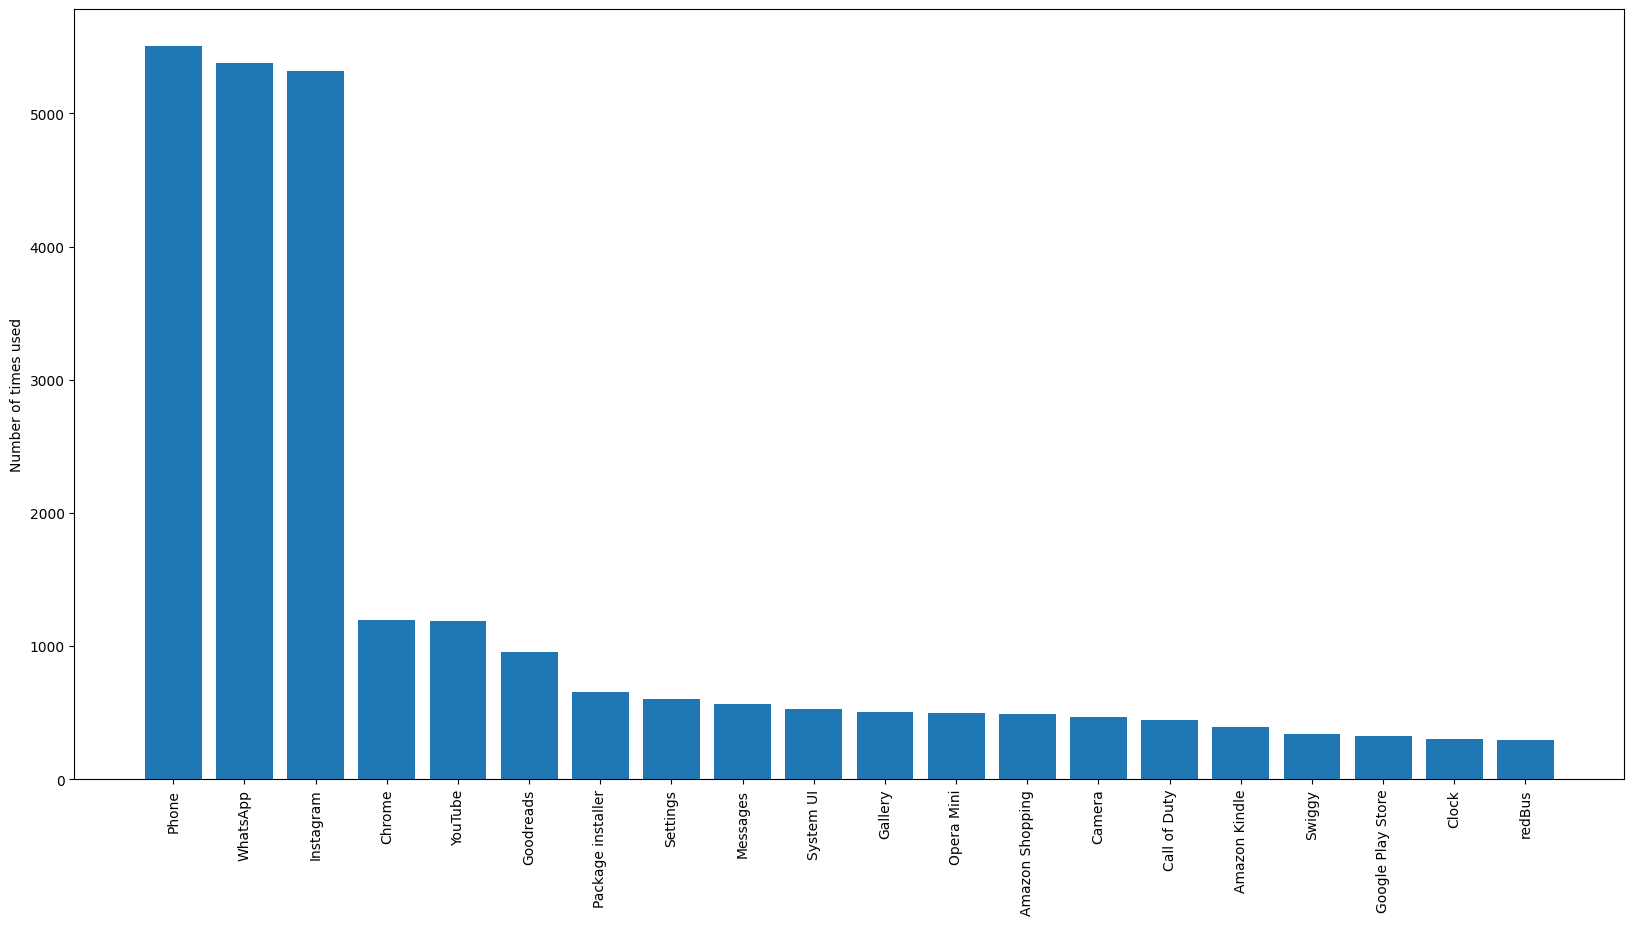

In [44]:
most_frequent_apps = np.argsort(-counts)[:20]
print(most_frequent_apps)

# Graph the distribution of the dataset with the app names as labels
# Only include the 20 most frequent apps

plt.figure(figsize=(20,10))
plt.bar(label_encoder.inverse_transform(most_frequent_apps), counts[most_frequent_apps])
plt.xticks(rotation=90)
plt.ylabel("Number of times used")
plt.show()



# Conclusions

So, if we take the 20 most frequent apps, we can see that, except for the big three, the rest of them are more or less the same in terms of aparitions. This indicates a really skewed dataset. However, this does not mean that the data does not reflect real life. If Twitter and maybe TikTok were included in the apps on that phone, they would also take a big part of the aparitions, and the rest of the apps wouldn't be used as much.